# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

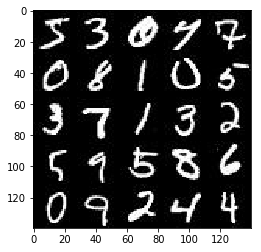

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

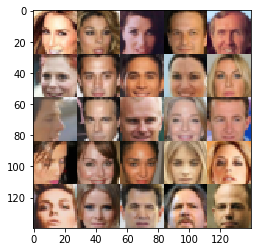

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
     
        # 28->14->7->3.5  doesn't work
        # opt1=[28,14,7,7]
        # opt2=[28,14,14,7]
        # opt3=[28,28,14,7]
        x=images
        alpha=0.2 # Mat uses 0.2 in DCGAN

        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # is_train = True -> reuse->False
    # is_train = False -> reuse->True

    alpha=0.2 # Mat uses 0.2 in DCGAN
        
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # 7x7x512 now
    
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
    
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
    
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    image_width=data_shape[1]
    image_height=data_shape[2]
    image_channels=data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []    

    print_every=25
    show_every=100
    batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model

                #The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.
                batch_images = batch_images*2.0  # rescale to -1, 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images,
                                                     learn_rate: learning_rate})

                if (batch_i+1) % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batches {}/{}...".format(batch_i+1, batches),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if (batch_i+1) % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        
    return losses, samples              

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batches 25/1500... Discriminator Loss: 1.6668... Generator Loss: 6.6307
Epoch 1/2... Batches 50/1500... Discriminator Loss: 0.2726... Generator Loss: 2.5226
Epoch 1/2... Batches 75/1500... Discriminator Loss: 0.9022... Generator Loss: 1.6180
Epoch 1/2... Batches 100/1500... Discriminator Loss: 0.6528... Generator Loss: 1.0582


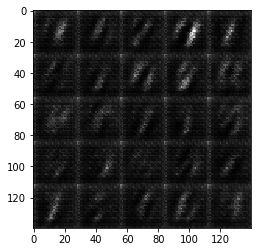

Epoch 1/2... Batches 125/1500... Discriminator Loss: 0.7601... Generator Loss: 1.1437
Epoch 1/2... Batches 150/1500... Discriminator Loss: 0.7913... Generator Loss: 1.4880
Epoch 1/2... Batches 175/1500... Discriminator Loss: 1.4058... Generator Loss: 0.4462
Epoch 1/2... Batches 200/1500... Discriminator Loss: 0.7508... Generator Loss: 2.3828


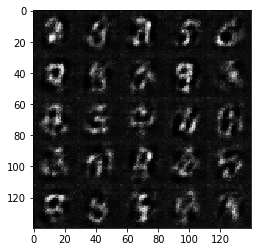

Epoch 1/2... Batches 225/1500... Discriminator Loss: 0.5443... Generator Loss: 2.0514
Epoch 1/2... Batches 250/1500... Discriminator Loss: 0.8706... Generator Loss: 2.6104
Epoch 1/2... Batches 275/1500... Discriminator Loss: 1.0610... Generator Loss: 3.4010
Epoch 1/2... Batches 300/1500... Discriminator Loss: 0.6235... Generator Loss: 1.9971


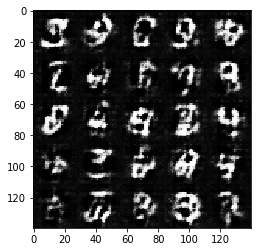

Epoch 1/2... Batches 325/1500... Discriminator Loss: 0.5138... Generator Loss: 1.2337
Epoch 1/2... Batches 350/1500... Discriminator Loss: 0.8008... Generator Loss: 0.9142
Epoch 1/2... Batches 375/1500... Discriminator Loss: 0.4976... Generator Loss: 2.5862
Epoch 1/2... Batches 400/1500... Discriminator Loss: 0.3771... Generator Loss: 1.7107


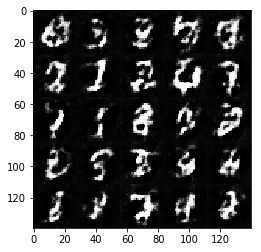

Epoch 1/2... Batches 425/1500... Discriminator Loss: 1.4834... Generator Loss: 0.3259
Epoch 1/2... Batches 450/1500... Discriminator Loss: 0.3986... Generator Loss: 2.1157
Epoch 1/2... Batches 475/1500... Discriminator Loss: 0.7333... Generator Loss: 0.8049
Epoch 1/2... Batches 500/1500... Discriminator Loss: 1.3620... Generator Loss: 0.6101


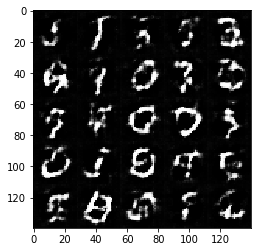

Epoch 1/2... Batches 525/1500... Discriminator Loss: 0.8353... Generator Loss: 0.9367
Epoch 1/2... Batches 550/1500... Discriminator Loss: 0.6190... Generator Loss: 1.8307
Epoch 1/2... Batches 575/1500... Discriminator Loss: 0.5382... Generator Loss: 1.2507
Epoch 1/2... Batches 600/1500... Discriminator Loss: 0.5661... Generator Loss: 2.6397


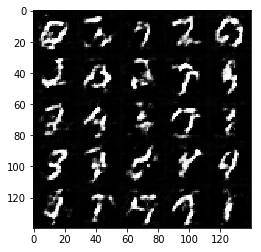

Epoch 1/2... Batches 625/1500... Discriminator Loss: 0.6136... Generator Loss: 1.2056
Epoch 1/2... Batches 650/1500... Discriminator Loss: 0.4369... Generator Loss: 1.9771
Epoch 1/2... Batches 675/1500... Discriminator Loss: 0.4851... Generator Loss: 1.2877
Epoch 1/2... Batches 700/1500... Discriminator Loss: 0.6953... Generator Loss: 1.0163


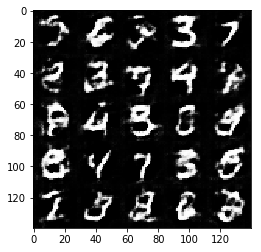

Epoch 1/2... Batches 725/1500... Discriminator Loss: 0.4683... Generator Loss: 1.5218
Epoch 1/2... Batches 750/1500... Discriminator Loss: 1.0361... Generator Loss: 3.6559
Epoch 1/2... Batches 775/1500... Discriminator Loss: 0.6372... Generator Loss: 1.1971
Epoch 1/2... Batches 800/1500... Discriminator Loss: 0.5766... Generator Loss: 1.2472


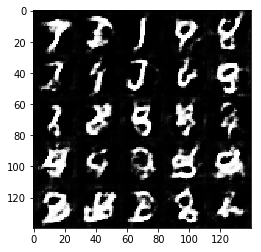

Epoch 1/2... Batches 825/1500... Discriminator Loss: 1.5846... Generator Loss: 0.3860
Epoch 1/2... Batches 850/1500... Discriminator Loss: 1.1414... Generator Loss: 0.5107
Epoch 1/2... Batches 875/1500... Discriminator Loss: 0.5081... Generator Loss: 1.5744
Epoch 1/2... Batches 900/1500... Discriminator Loss: 0.5134... Generator Loss: 1.8240


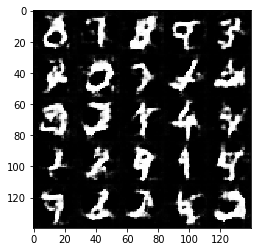

Epoch 1/2... Batches 925/1500... Discriminator Loss: 0.5777... Generator Loss: 2.0478
Epoch 1/2... Batches 950/1500... Discriminator Loss: 0.3985... Generator Loss: 1.5058
Epoch 1/2... Batches 975/1500... Discriminator Loss: 0.9375... Generator Loss: 0.7623
Epoch 1/2... Batches 1000/1500... Discriminator Loss: 0.6448... Generator Loss: 0.9778


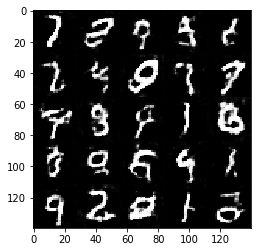

Epoch 1/2... Batches 1025/1500... Discriminator Loss: 0.9679... Generator Loss: 4.5453
Epoch 1/2... Batches 1050/1500... Discriminator Loss: 1.0969... Generator Loss: 0.6099
Epoch 1/2... Batches 1075/1500... Discriminator Loss: 0.6815... Generator Loss: 0.9489
Epoch 1/2... Batches 1100/1500... Discriminator Loss: 0.4605... Generator Loss: 1.4310


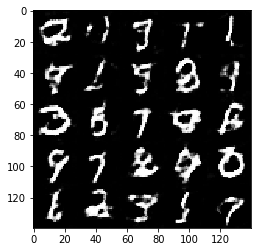

Epoch 1/2... Batches 1125/1500... Discriminator Loss: 1.0492... Generator Loss: 0.6682
Epoch 1/2... Batches 1150/1500... Discriminator Loss: 5.6004... Generator Loss: 0.0324
Epoch 1/2... Batches 1175/1500... Discriminator Loss: 0.9081... Generator Loss: 0.9041
Epoch 1/2... Batches 1200/1500... Discriminator Loss: 0.3934... Generator Loss: 1.7887


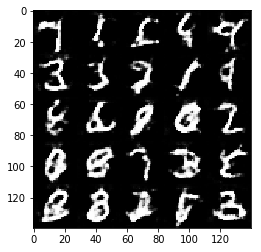

Epoch 1/2... Batches 1225/1500... Discriminator Loss: 0.8668... Generator Loss: 0.7099
Epoch 1/2... Batches 1250/1500... Discriminator Loss: 0.3563... Generator Loss: 1.8939
Epoch 1/2... Batches 1275/1500... Discriminator Loss: 1.2805... Generator Loss: 3.3312
Epoch 1/2... Batches 1300/1500... Discriminator Loss: 0.4798... Generator Loss: 1.6638


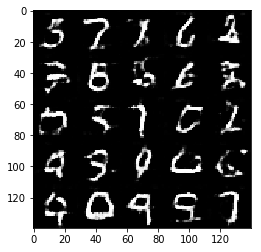

Epoch 1/2... Batches 1325/1500... Discriminator Loss: 0.6288... Generator Loss: 1.2349
Epoch 1/2... Batches 1350/1500... Discriminator Loss: 0.5780... Generator Loss: 1.1442
Epoch 1/2... Batches 1375/1500... Discriminator Loss: 1.2363... Generator Loss: 3.1579
Epoch 1/2... Batches 1400/1500... Discriminator Loss: 0.7417... Generator Loss: 1.0602


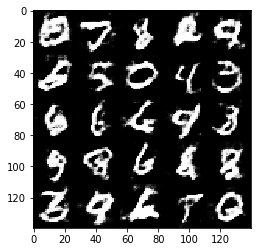

Epoch 1/2... Batches 1425/1500... Discriminator Loss: 1.5183... Generator Loss: 0.3261
Epoch 1/2... Batches 1450/1500... Discriminator Loss: 0.7608... Generator Loss: 0.7690
Epoch 1/2... Batches 1475/1500... Discriminator Loss: 0.6869... Generator Loss: 1.0923
Epoch 1/2... Batches 1500/1500... Discriminator Loss: 0.4939... Generator Loss: 1.2243


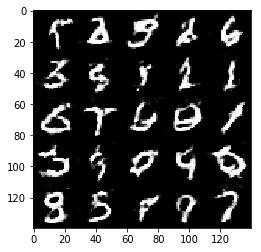

Epoch 2/2... Batches 25/1500... Discriminator Loss: 1.0309... Generator Loss: 0.6765
Epoch 2/2... Batches 50/1500... Discriminator Loss: 0.3733... Generator Loss: 1.5883
Epoch 2/2... Batches 75/1500... Discriminator Loss: 0.4962... Generator Loss: 1.4769
Epoch 2/2... Batches 100/1500... Discriminator Loss: 0.6231... Generator Loss: 1.4028


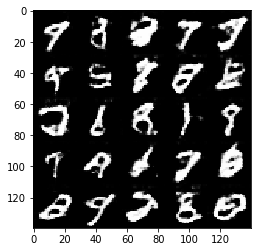

Epoch 2/2... Batches 125/1500... Discriminator Loss: 0.5605... Generator Loss: 1.1095
Epoch 2/2... Batches 150/1500... Discriminator Loss: 0.4615... Generator Loss: 1.3572
Epoch 2/2... Batches 175/1500... Discriminator Loss: 0.9109... Generator Loss: 0.6343
Epoch 2/2... Batches 200/1500... Discriminator Loss: 0.7256... Generator Loss: 0.8381


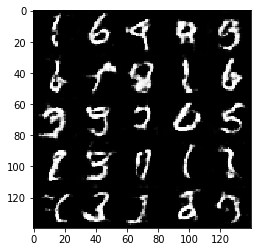

Epoch 2/2... Batches 225/1500... Discriminator Loss: 0.7000... Generator Loss: 0.8626
Epoch 2/2... Batches 250/1500... Discriminator Loss: 0.4482... Generator Loss: 1.7570
Epoch 2/2... Batches 275/1500... Discriminator Loss: 0.9196... Generator Loss: 4.2316
Epoch 2/2... Batches 300/1500... Discriminator Loss: 0.6911... Generator Loss: 0.8775


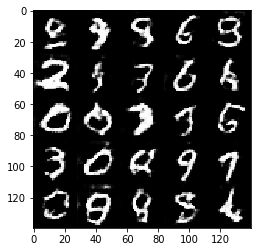

Epoch 2/2... Batches 325/1500... Discriminator Loss: 0.4249... Generator Loss: 1.5635
Epoch 2/2... Batches 350/1500... Discriminator Loss: 0.7566... Generator Loss: 1.0627
Epoch 2/2... Batches 375/1500... Discriminator Loss: 0.4136... Generator Loss: 1.4457
Epoch 2/2... Batches 400/1500... Discriminator Loss: 0.6008... Generator Loss: 1.2574


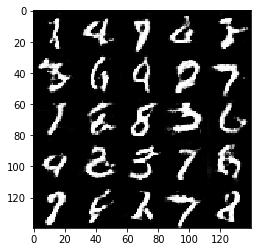

Epoch 2/2... Batches 425/1500... Discriminator Loss: 0.7864... Generator Loss: 0.9421
Epoch 2/2... Batches 450/1500... Discriminator Loss: 0.6390... Generator Loss: 0.9967
Epoch 2/2... Batches 475/1500... Discriminator Loss: 0.7687... Generator Loss: 0.9846
Epoch 2/2... Batches 500/1500... Discriminator Loss: 0.6520... Generator Loss: 1.0675


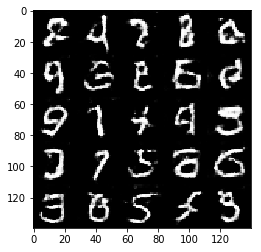

Epoch 2/2... Batches 525/1500... Discriminator Loss: 0.3911... Generator Loss: 2.6459
Epoch 2/2... Batches 550/1500... Discriminator Loss: 0.9043... Generator Loss: 0.8407
Epoch 2/2... Batches 575/1500... Discriminator Loss: 0.9735... Generator Loss: 0.7862
Epoch 2/2... Batches 600/1500... Discriminator Loss: 0.4801... Generator Loss: 1.3957


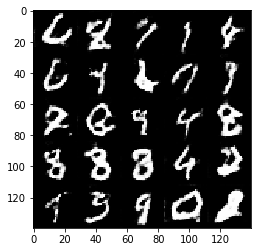

Epoch 2/2... Batches 625/1500... Discriminator Loss: 1.0259... Generator Loss: 0.8115
Epoch 2/2... Batches 650/1500... Discriminator Loss: 0.5456... Generator Loss: 1.2391
Epoch 2/2... Batches 675/1500... Discriminator Loss: 0.9631... Generator Loss: 0.7095
Epoch 2/2... Batches 700/1500... Discriminator Loss: 0.5419... Generator Loss: 1.1867


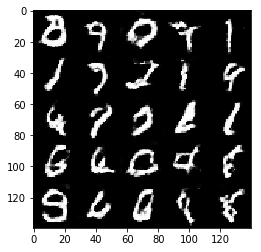

Epoch 2/2... Batches 725/1500... Discriminator Loss: 0.5569... Generator Loss: 1.1714
Epoch 2/2... Batches 750/1500... Discriminator Loss: 1.4594... Generator Loss: 0.5599
Epoch 2/2... Batches 775/1500... Discriminator Loss: 0.6209... Generator Loss: 0.9957
Epoch 2/2... Batches 800/1500... Discriminator Loss: 0.6857... Generator Loss: 0.9429


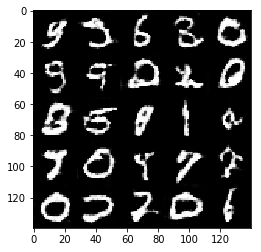

Epoch 2/2... Batches 825/1500... Discriminator Loss: 0.8756... Generator Loss: 0.7289
Epoch 2/2... Batches 850/1500... Discriminator Loss: 2.6708... Generator Loss: 0.1485
Epoch 2/2... Batches 875/1500... Discriminator Loss: 0.5265... Generator Loss: 1.2075
Epoch 2/2... Batches 900/1500... Discriminator Loss: 0.6178... Generator Loss: 1.1542


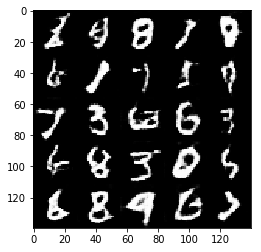

Epoch 2/2... Batches 925/1500... Discriminator Loss: 0.7123... Generator Loss: 1.0752
Epoch 2/2... Batches 950/1500... Discriminator Loss: 0.7112... Generator Loss: 0.9113
Epoch 2/2... Batches 975/1500... Discriminator Loss: 0.5804... Generator Loss: 1.0833
Epoch 2/2... Batches 1000/1500... Discriminator Loss: 0.8302... Generator Loss: 0.8629


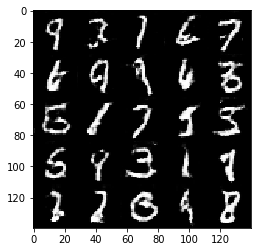

Epoch 2/2... Batches 1025/1500... Discriminator Loss: 0.6145... Generator Loss: 1.1758
Epoch 2/2... Batches 1050/1500... Discriminator Loss: 0.4227... Generator Loss: 2.0234
Epoch 2/2... Batches 1075/1500... Discriminator Loss: 1.6241... Generator Loss: 0.3714
Epoch 2/2... Batches 1100/1500... Discriminator Loss: 0.5429... Generator Loss: 1.4471


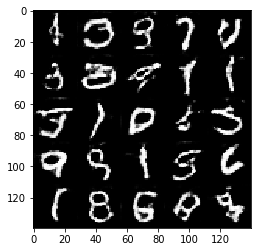

Epoch 2/2... Batches 1125/1500... Discriminator Loss: 0.8902... Generator Loss: 0.7820
Epoch 2/2... Batches 1150/1500... Discriminator Loss: 0.3957... Generator Loss: 1.4293
Epoch 2/2... Batches 1175/1500... Discriminator Loss: 0.3739... Generator Loss: 2.1339
Epoch 2/2... Batches 1200/1500... Discriminator Loss: 0.4578... Generator Loss: 1.4115


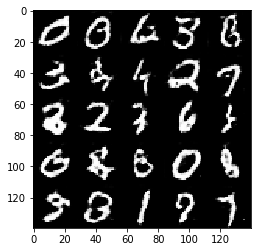

Epoch 2/2... Batches 1225/1500... Discriminator Loss: 0.9444... Generator Loss: 0.7909
Epoch 2/2... Batches 1250/1500... Discriminator Loss: 0.3906... Generator Loss: 1.6440
Epoch 2/2... Batches 1275/1500... Discriminator Loss: 0.4591... Generator Loss: 1.5460
Epoch 2/2... Batches 1300/1500... Discriminator Loss: 0.4926... Generator Loss: 2.1673


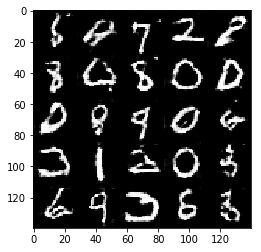

Epoch 2/2... Batches 1325/1500... Discriminator Loss: 0.7994... Generator Loss: 0.8510
Epoch 2/2... Batches 1350/1500... Discriminator Loss: 0.8109... Generator Loss: 1.2573
Epoch 2/2... Batches 1375/1500... Discriminator Loss: 1.1313... Generator Loss: 1.5511
Epoch 2/2... Batches 1400/1500... Discriminator Loss: 0.5428... Generator Loss: 1.5457


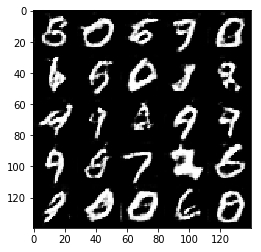

Epoch 2/2... Batches 1425/1500... Discriminator Loss: 0.8936... Generator Loss: 0.8880
Epoch 2/2... Batches 1450/1500... Discriminator Loss: 0.4026... Generator Loss: 1.7772
Epoch 2/2... Batches 1475/1500... Discriminator Loss: 0.6678... Generator Loss: 1.0933
Epoch 2/2... Batches 1500/1500... Discriminator Loss: 0.5138... Generator Loss: 1.3314


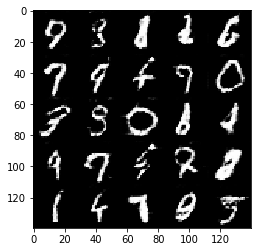

In [12]:
batch_size = 40
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batches 25/5064... Discriminator Loss: 0.1669... Generator Loss: 2.9305
Epoch 1/1... Batches 50/5064... Discriminator Loss: 0.4332... Generator Loss: 1.3718
Epoch 1/1... Batches 75/5064... Discriminator Loss: 0.9718... Generator Loss: 5.4453
Epoch 1/1... Batches 100/5064... Discriminator Loss: 0.7315... Generator Loss: 1.0668


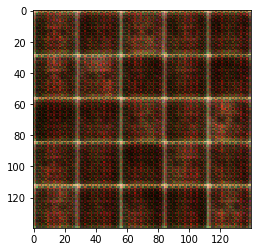

Epoch 1/1... Batches 125/5064... Discriminator Loss: 0.5628... Generator Loss: 1.4310
Epoch 1/1... Batches 150/5064... Discriminator Loss: 0.7718... Generator Loss: 1.0221
Epoch 1/1... Batches 175/5064... Discriminator Loss: 1.3423... Generator Loss: 0.5347
Epoch 1/1... Batches 200/5064... Discriminator Loss: 0.7515... Generator Loss: 5.3196


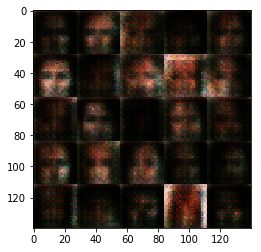

Epoch 1/1... Batches 225/5064... Discriminator Loss: 0.7339... Generator Loss: 1.1405
Epoch 1/1... Batches 250/5064... Discriminator Loss: 0.7764... Generator Loss: 3.9511
Epoch 1/1... Batches 275/5064... Discriminator Loss: 0.6740... Generator Loss: 2.1781
Epoch 1/1... Batches 300/5064... Discriminator Loss: 1.2699... Generator Loss: 2.6302


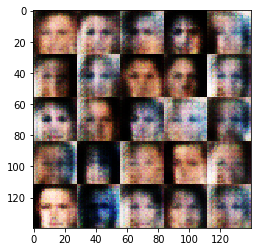

Epoch 1/1... Batches 325/5064... Discriminator Loss: 0.5734... Generator Loss: 1.5771
Epoch 1/1... Batches 350/5064... Discriminator Loss: 1.2852... Generator Loss: 0.5783
Epoch 1/1... Batches 375/5064... Discriminator Loss: 0.9069... Generator Loss: 0.9744
Epoch 1/1... Batches 400/5064... Discriminator Loss: 1.4005... Generator Loss: 0.5119


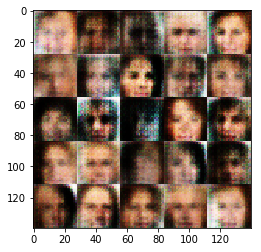

Epoch 1/1... Batches 425/5064... Discriminator Loss: 0.7011... Generator Loss: 1.3790
Epoch 1/1... Batches 450/5064... Discriminator Loss: 1.0454... Generator Loss: 2.3520
Epoch 1/1... Batches 475/5064... Discriminator Loss: 1.0093... Generator Loss: 0.7664
Epoch 1/1... Batches 500/5064... Discriminator Loss: 0.7701... Generator Loss: 1.5934


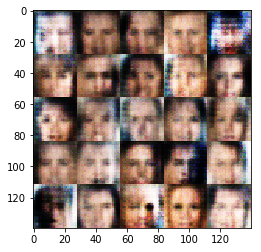

Epoch 1/1... Batches 525/5064... Discriminator Loss: 1.3648... Generator Loss: 0.4367
Epoch 1/1... Batches 550/5064... Discriminator Loss: 0.9940... Generator Loss: 0.9210
Epoch 1/1... Batches 575/5064... Discriminator Loss: 0.7719... Generator Loss: 1.6180
Epoch 1/1... Batches 600/5064... Discriminator Loss: 1.3916... Generator Loss: 1.8529


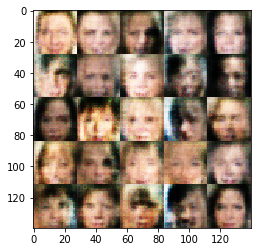

Epoch 1/1... Batches 625/5064... Discriminator Loss: 0.9991... Generator Loss: 0.8902
Epoch 1/1... Batches 650/5064... Discriminator Loss: 1.6945... Generator Loss: 0.3372
Epoch 1/1... Batches 675/5064... Discriminator Loss: 0.9660... Generator Loss: 1.1141
Epoch 1/1... Batches 700/5064... Discriminator Loss: 1.3557... Generator Loss: 1.6102


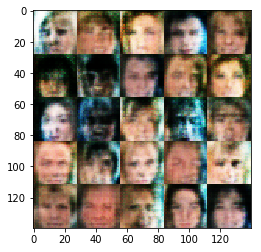

Epoch 1/1... Batches 725/5064... Discriminator Loss: 1.0070... Generator Loss: 1.0067
Epoch 1/1... Batches 750/5064... Discriminator Loss: 1.1703... Generator Loss: 0.5823
Epoch 1/1... Batches 775/5064... Discriminator Loss: 0.8915... Generator Loss: 1.6587
Epoch 1/1... Batches 800/5064... Discriminator Loss: 1.5027... Generator Loss: 0.3276


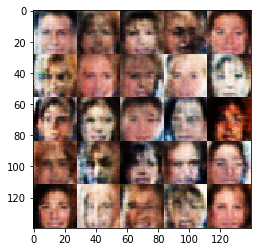

Epoch 1/1... Batches 825/5064... Discriminator Loss: 0.8964... Generator Loss: 1.2002
Epoch 1/1... Batches 850/5064... Discriminator Loss: 0.9072... Generator Loss: 0.9342
Epoch 1/1... Batches 875/5064... Discriminator Loss: 1.0674... Generator Loss: 1.5597
Epoch 1/1... Batches 900/5064... Discriminator Loss: 1.0697... Generator Loss: 0.6741


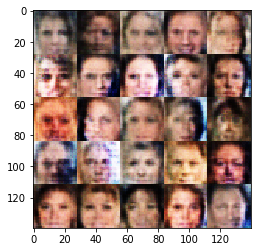

Epoch 1/1... Batches 925/5064... Discriminator Loss: 0.9369... Generator Loss: 0.8861
Epoch 1/1... Batches 950/5064... Discriminator Loss: 1.0854... Generator Loss: 0.6064
Epoch 1/1... Batches 975/5064... Discriminator Loss: 1.0502... Generator Loss: 0.8948
Epoch 1/1... Batches 1000/5064... Discriminator Loss: 0.9352... Generator Loss: 1.2365


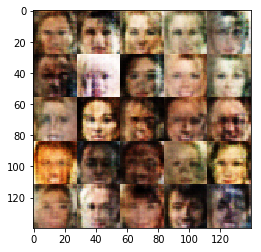

Epoch 1/1... Batches 1025/5064... Discriminator Loss: 0.7595... Generator Loss: 1.3164
Epoch 1/1... Batches 1050/5064... Discriminator Loss: 1.0258... Generator Loss: 0.7069
Epoch 1/1... Batches 1075/5064... Discriminator Loss: 0.9579... Generator Loss: 1.4659
Epoch 1/1... Batches 1100/5064... Discriminator Loss: 1.2872... Generator Loss: 0.5051


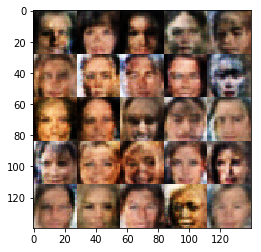

Epoch 1/1... Batches 1125/5064... Discriminator Loss: 0.8528... Generator Loss: 0.8653
Epoch 1/1... Batches 1150/5064... Discriminator Loss: 1.4153... Generator Loss: 0.6284
Epoch 1/1... Batches 1175/5064... Discriminator Loss: 0.9645... Generator Loss: 0.8203
Epoch 1/1... Batches 1200/5064... Discriminator Loss: 0.7508... Generator Loss: 1.0865


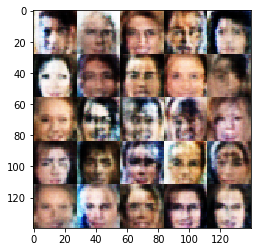

Epoch 1/1... Batches 1225/5064... Discriminator Loss: 1.0405... Generator Loss: 0.7948
Epoch 1/1... Batches 1250/5064... Discriminator Loss: 0.9876... Generator Loss: 1.0993
Epoch 1/1... Batches 1275/5064... Discriminator Loss: 0.9505... Generator Loss: 0.7685
Epoch 1/1... Batches 1300/5064... Discriminator Loss: 0.9027... Generator Loss: 0.9856


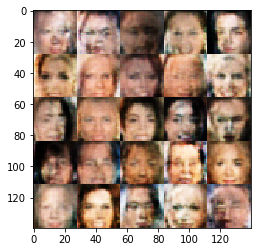

Epoch 1/1... Batches 1325/5064... Discriminator Loss: 0.9997... Generator Loss: 0.9571
Epoch 1/1... Batches 1350/5064... Discriminator Loss: 0.8256... Generator Loss: 1.5476
Epoch 1/1... Batches 1375/5064... Discriminator Loss: 0.9972... Generator Loss: 1.8075
Epoch 1/1... Batches 1400/5064... Discriminator Loss: 0.8451... Generator Loss: 1.1351


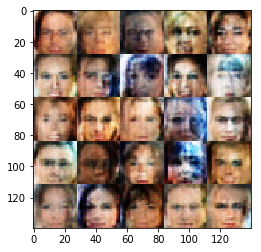

Epoch 1/1... Batches 1425/5064... Discriminator Loss: 0.8174... Generator Loss: 1.3370
Epoch 1/1... Batches 1450/5064... Discriminator Loss: 0.7037... Generator Loss: 1.6127
Epoch 1/1... Batches 1475/5064... Discriminator Loss: 0.8042... Generator Loss: 1.5616
Epoch 1/1... Batches 1500/5064... Discriminator Loss: 0.7738... Generator Loss: 0.9552


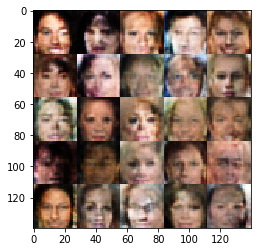

Epoch 1/1... Batches 1525/5064... Discriminator Loss: 0.5033... Generator Loss: 1.6564
Epoch 1/1... Batches 1550/5064... Discriminator Loss: 0.5234... Generator Loss: 1.3319
Epoch 1/1... Batches 1575/5064... Discriminator Loss: 1.2646... Generator Loss: 0.5010
Epoch 1/1... Batches 1600/5064... Discriminator Loss: 0.8674... Generator Loss: 2.3358


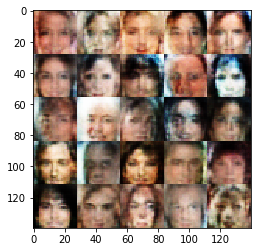

Epoch 1/1... Batches 1625/5064... Discriminator Loss: 0.6922... Generator Loss: 2.1297
Epoch 1/1... Batches 1650/5064... Discriminator Loss: 0.8320... Generator Loss: 0.9724
Epoch 1/1... Batches 1675/5064... Discriminator Loss: 1.0956... Generator Loss: 1.1904
Epoch 1/1... Batches 1700/5064... Discriminator Loss: 1.5094... Generator Loss: 0.3295


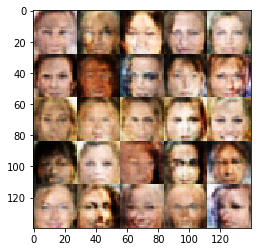

Epoch 1/1... Batches 1725/5064... Discriminator Loss: 0.6196... Generator Loss: 2.2823
Epoch 1/1... Batches 1750/5064... Discriminator Loss: 0.9964... Generator Loss: 0.8275
Epoch 1/1... Batches 1775/5064... Discriminator Loss: 1.0517... Generator Loss: 1.2775
Epoch 1/1... Batches 1800/5064... Discriminator Loss: 0.8852... Generator Loss: 0.7987


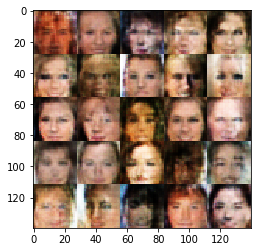

Epoch 1/1... Batches 1825/5064... Discriminator Loss: 0.8120... Generator Loss: 0.8385
Epoch 1/1... Batches 1850/5064... Discriminator Loss: 0.7902... Generator Loss: 1.0107
Epoch 1/1... Batches 1875/5064... Discriminator Loss: 0.6400... Generator Loss: 1.4079
Epoch 1/1... Batches 1900/5064... Discriminator Loss: 0.8165... Generator Loss: 1.0764


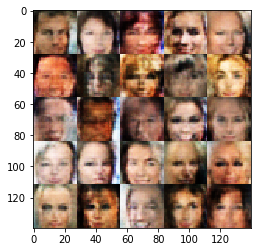

Epoch 1/1... Batches 1925/5064... Discriminator Loss: 0.9529... Generator Loss: 0.6937
Epoch 1/1... Batches 1950/5064... Discriminator Loss: 0.8338... Generator Loss: 1.3946
Epoch 1/1... Batches 1975/5064... Discriminator Loss: 1.1607... Generator Loss: 1.0655
Epoch 1/1... Batches 2000/5064... Discriminator Loss: 1.1918... Generator Loss: 0.6915


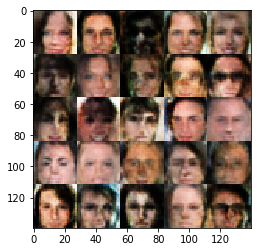

Epoch 1/1... Batches 2025/5064... Discriminator Loss: 0.9829... Generator Loss: 0.7383
Epoch 1/1... Batches 2050/5064... Discriminator Loss: 0.9696... Generator Loss: 0.8968
Epoch 1/1... Batches 2075/5064... Discriminator Loss: 0.9506... Generator Loss: 0.7144
Epoch 1/1... Batches 2100/5064... Discriminator Loss: 1.3315... Generator Loss: 0.4400


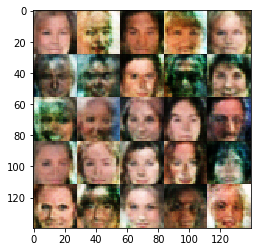

Epoch 1/1... Batches 2125/5064... Discriminator Loss: 0.8951... Generator Loss: 1.0144
Epoch 1/1... Batches 2150/5064... Discriminator Loss: 0.6981... Generator Loss: 1.2327
Epoch 1/1... Batches 2175/5064... Discriminator Loss: 1.0408... Generator Loss: 0.8534
Epoch 1/1... Batches 2200/5064... Discriminator Loss: 1.0506... Generator Loss: 0.7559


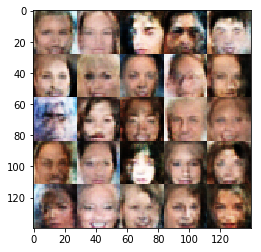

Epoch 1/1... Batches 2225/5064... Discriminator Loss: 0.8678... Generator Loss: 0.8209
Epoch 1/1... Batches 2250/5064... Discriminator Loss: 1.0594... Generator Loss: 0.8844
Epoch 1/1... Batches 2275/5064... Discriminator Loss: 0.8816... Generator Loss: 0.7682
Epoch 1/1... Batches 2300/5064... Discriminator Loss: 0.7521... Generator Loss: 2.0431


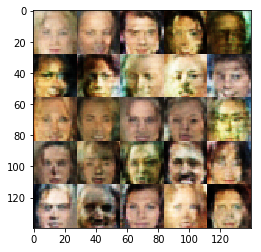

Epoch 1/1... Batches 2325/5064... Discriminator Loss: 1.1286... Generator Loss: 0.6955
Epoch 1/1... Batches 2350/5064... Discriminator Loss: 1.0989... Generator Loss: 0.6268
Epoch 1/1... Batches 2375/5064... Discriminator Loss: 0.8163... Generator Loss: 1.4087
Epoch 1/1... Batches 2400/5064... Discriminator Loss: 0.7778... Generator Loss: 1.4146


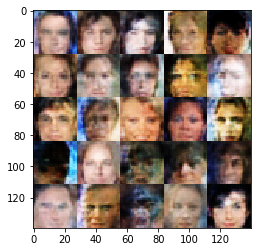

Epoch 1/1... Batches 2425/5064... Discriminator Loss: 1.3175... Generator Loss: 0.4679
Epoch 1/1... Batches 2450/5064... Discriminator Loss: 1.0130... Generator Loss: 0.6836
Epoch 1/1... Batches 2475/5064... Discriminator Loss: 1.4155... Generator Loss: 0.3711
Epoch 1/1... Batches 2500/5064... Discriminator Loss: 0.9302... Generator Loss: 0.6917


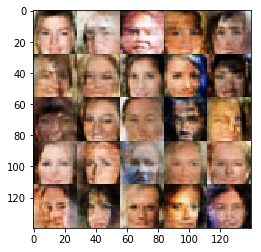

Epoch 1/1... Batches 2525/5064... Discriminator Loss: 0.6685... Generator Loss: 1.2892
Epoch 1/1... Batches 2550/5064... Discriminator Loss: 1.0303... Generator Loss: 1.8132
Epoch 1/1... Batches 2575/5064... Discriminator Loss: 1.0016... Generator Loss: 0.7834
Epoch 1/1... Batches 2600/5064... Discriminator Loss: 0.7669... Generator Loss: 0.9158


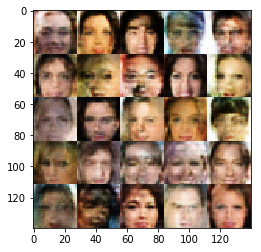

Epoch 1/1... Batches 2625/5064... Discriminator Loss: 0.7925... Generator Loss: 0.8879
Epoch 1/1... Batches 2650/5064... Discriminator Loss: 0.6765... Generator Loss: 1.0364
Epoch 1/1... Batches 2675/5064... Discriminator Loss: 1.2717... Generator Loss: 1.4500
Epoch 1/1... Batches 2700/5064... Discriminator Loss: 0.8764... Generator Loss: 1.4782


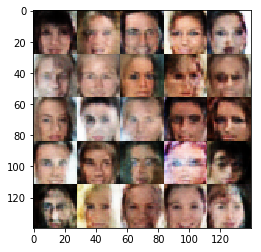

Epoch 1/1... Batches 2725/5064... Discriminator Loss: 0.7490... Generator Loss: 1.1500
Epoch 1/1... Batches 2750/5064... Discriminator Loss: 0.9343... Generator Loss: 0.9119
Epoch 1/1... Batches 2775/5064... Discriminator Loss: 0.8637... Generator Loss: 1.3104
Epoch 1/1... Batches 2800/5064... Discriminator Loss: 1.2799... Generator Loss: 0.5319


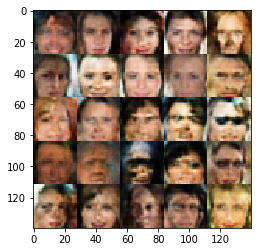

Epoch 1/1... Batches 2825/5064... Discriminator Loss: 0.8334... Generator Loss: 0.9185
Epoch 1/1... Batches 2850/5064... Discriminator Loss: 0.9670... Generator Loss: 0.7637
Epoch 1/1... Batches 2875/5064... Discriminator Loss: 0.9030... Generator Loss: 0.7869
Epoch 1/1... Batches 2900/5064... Discriminator Loss: 1.2233... Generator Loss: 0.5432


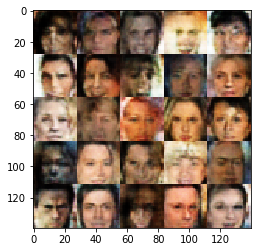

Epoch 1/1... Batches 2925/5064... Discriminator Loss: 0.5470... Generator Loss: 1.5097
Epoch 1/1... Batches 2950/5064... Discriminator Loss: 1.0863... Generator Loss: 0.5849
Epoch 1/1... Batches 2975/5064... Discriminator Loss: 1.0165... Generator Loss: 1.2810
Epoch 1/1... Batches 3000/5064... Discriminator Loss: 0.8184... Generator Loss: 1.1163


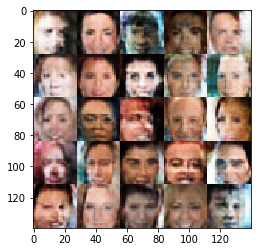

Epoch 1/1... Batches 3025/5064... Discriminator Loss: 0.7762... Generator Loss: 1.1542
Epoch 1/1... Batches 3050/5064... Discriminator Loss: 1.3238... Generator Loss: 0.4504
Epoch 1/1... Batches 3075/5064... Discriminator Loss: 1.0828... Generator Loss: 0.6473
Epoch 1/1... Batches 3100/5064... Discriminator Loss: 1.1737... Generator Loss: 0.5688


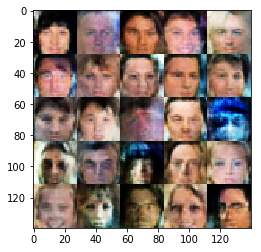

Epoch 1/1... Batches 3125/5064... Discriminator Loss: 0.6499... Generator Loss: 1.0167
Epoch 1/1... Batches 3150/5064... Discriminator Loss: 0.9842... Generator Loss: 0.6935
Epoch 1/1... Batches 3175/5064... Discriminator Loss: 0.9382... Generator Loss: 0.8563
Epoch 1/1... Batches 3200/5064... Discriminator Loss: 0.7643... Generator Loss: 0.8643


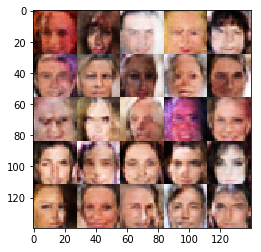

Epoch 1/1... Batches 3225/5064... Discriminator Loss: 1.1663... Generator Loss: 0.5138
Epoch 1/1... Batches 3250/5064... Discriminator Loss: 1.0348... Generator Loss: 0.7246
Epoch 1/1... Batches 3275/5064... Discriminator Loss: 0.6418... Generator Loss: 1.6705
Epoch 1/1... Batches 3300/5064... Discriminator Loss: 1.1031... Generator Loss: 0.6798


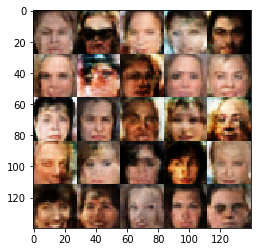

Epoch 1/1... Batches 3325/5064... Discriminator Loss: 1.0741... Generator Loss: 0.5789
Epoch 1/1... Batches 3350/5064... Discriminator Loss: 1.0839... Generator Loss: 0.5736
Epoch 1/1... Batches 3375/5064... Discriminator Loss: 0.9478... Generator Loss: 0.6773
Epoch 1/1... Batches 3400/5064... Discriminator Loss: 0.6567... Generator Loss: 1.0411


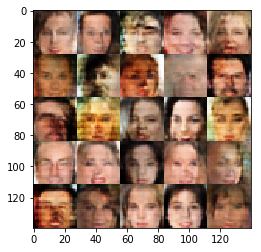

Epoch 1/1... Batches 3425/5064... Discriminator Loss: 0.9806... Generator Loss: 0.7259
Epoch 1/1... Batches 3450/5064... Discriminator Loss: 1.0238... Generator Loss: 0.6977
Epoch 1/1... Batches 3475/5064... Discriminator Loss: 1.2668... Generator Loss: 0.4814
Epoch 1/1... Batches 3500/5064... Discriminator Loss: 0.9882... Generator Loss: 0.8109


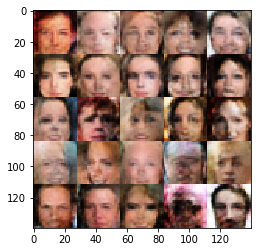

In [ ]:
batch_size = 40
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.